In [ ]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from file_manager import FileManager
fm = FileManager()

In [56]:
# Pass in player dataframe
def create_overview(df: pd.DataFrame):
    infocols: list[str,...] = ['date', 'name', 'team', 'opp', 'starter']
    statcols: list[str,...] = [col for col in df.columns if col not in infocols]

    
    # overview
    ov: dict[str,str|int|float] = {
        'name': df['name'].drop_duplicates().item(),
        'team(s)': ','.join(df['team'].drop_duplicates()),
        'played': len(df),
        'started': len(df.loc[df['starter']==1])
    }
    
    ov: dict[str, str|int|float] = {
        **ov,
        **{f'med-{stat}': np.median(df[stat]).round(2) for stat in statcols},
        # **{f'avg-{stat}': np.mean(df[stat]).round(2) for stat in ('fpts', 'mp')}
    }
    
    return pd.Series(ov)

In [151]:
# Return graph of player outcomes
def view_player(name: str, **kwargs):
    
    columns: list[str,...] = [
        'date',
        'name',
        'team',
        'opp',
        'mp',
        'fpts',
        'fppm',
        'usg',
        'pts',
        'ast',
        'trb',
        'starter'
    ]
    
    stats: list[str,...] = sum([
        columns,
        kwargs.get('stats', [])
    ], [])
    
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
    
    df: pd.DataFrame = (fm
                        .load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'] == name)
                                                  & df_['starter'].isin(starter_)
                                                 ])
                        [stats]
                       )
    
    print(create_overview(df))
    
    plot: str = kwargs.get('plot', 'histogram')
    plotkwargs = {kw:arg for kw,arg in kwargs.items() if kw not in ('stats','target', 'starter')}
    figsize = plotkwargs.get('figsize', (15,10))
    
    target: str = kwargs.get('target', 'fpts')
    
    
    if plot in ('hist', 'histogram'):
        return (df
                .plot
                .hist(
                    column=[target],
                    # Nondefault args for hist
                    # bins=plotkwargs.get('bins', 7),
                    figsize=figsize,
                    **plotkwargs
                )
               )
    
    if plot in ('box', 'boxplot'):
        return (df
                .plot
                .box(column=[target], figsize=figsize)
               )
    
    return None

name        Donovan Mitchell
team(s)                  CLE
played                    49
started                   49
med-mp                 36.82
med-fpts                40.5
med-fppm                1.16
med-usg                 0.32
med-pts                 28.0
med-ast                  5.0
med-trb                  4.0
dtype: object


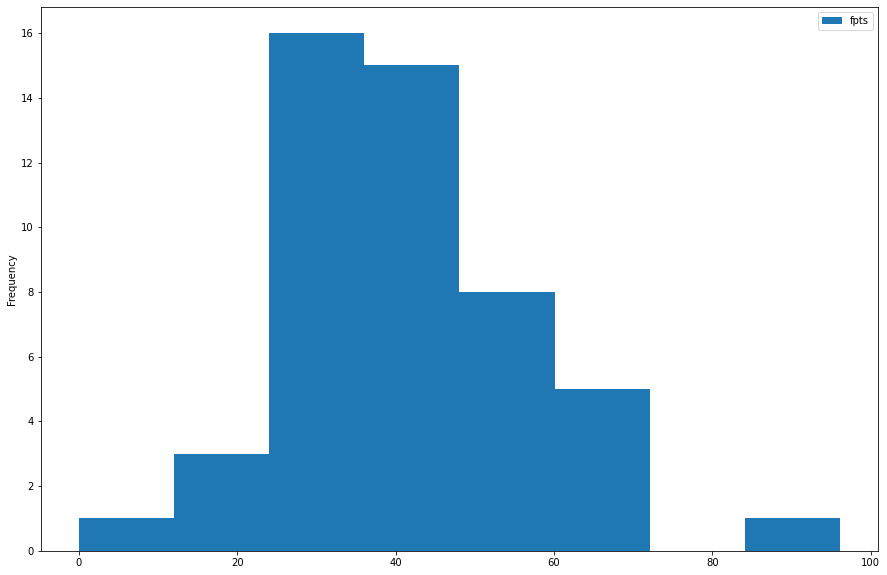

In [152]:
view_player(
    'Donovan Mitchell',
    # plot='box',
    bins=8,
    # width=10
);